In [353]:
import numpy as np
import pandas as pd

import os
import matplotlib.pyplot as plt
import pandas_datareader as web
import datetime as dt

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Loading and Preprocessing Data

In [354]:
amazon_df = pd.read_csv('AMZN_Daily_10year.csv')

In [355]:
def load_data(df, start, end):
    """
    Load data for the date range.

    :param start: The starting date for the data range (str or datetime)
    :param end: The ending date for the data range (str or datetime)
    :return: A dataframe containing the relevant stock data (pandas.DataFrame)
    """
    dataframe = df.copy()
    dataframe = dataframe.loc[(dataframe['Date'] > start) & (dataframe['Date'] < end), :]
    return dataframe

In [356]:
START_DATE = dt.datetime(2013,11,1)
END_DATE = dt.datetime(2021,11,1)

START_DATE_TEST = END_DATE

In [357]:
# Convert 'Date' to datetime format

amazon_df['Date'] = pd.to_datetime(amazon_df['Date'])

In [358]:
# Load the training data and scale the data.
# combined the scaled data into one array with dim [2012, 1]
# Also prepare the test inputs

# Set the number of days used for prediction
prediction_days = 90

#prepare training data
train_data = load_data(amazon_df,
                 start = START_DATE,
                 end = END_DATE)

price_scaler = MinMaxScaler() # default [0,1]
volume_scaler = MinMaxScaler()
scaled_price_data = price_scaler.fit_transform(train_data['Close'].values.reshape(-1,1)) # scale price data
scaled_volume_data = volume_scaler.fit_transform(train_data['Volume'].values.reshape(-1,1)) # scale volume data

scaled_training_input = np.concatenate((scaled_price_data, scaled_volume_data), axis=1) # combine scaled data

# prepare the test data
test_data = load_data(amazon_df,
start=START_DATE_TEST,
end=dt.datetime.now()
)

actual_prices = test_data['Close'].values

# Concatenate the training and test data
total_price_dataset = pd.concat((train_data['Close'], test_data['Close']), axis=0)
total_volume_dataset = pd.concat((train_data['Volume'], test_data['Volume']), axis=0)

# Extract the relevant portion of the dataset for model inputs
model_price_inputs = total_price_dataset[len(total_price_dataset) - len(test_data) - prediction_days:].values
model_volume_inputs = total_volume_dataset[len(total_volume_dataset) - len(test_data) - prediction_days:].values

# Reshape the model inputs to a 2D array with a single column
model_price_inputs = model_price_inputs.reshape(-1, 1)
model_volume_inputs = model_volume_inputs.reshape(-1, 1)

# Apply the same scaling used for training data to the model inputs
model_price_inputs = price_scaler.transform(model_price_inputs)
model_volume_inputs = volume_scaler.transform(model_volume_inputs)

combined_model_inputs = np.concatenate((model_price_inputs, model_volume_inputs), axis=1) # combine scaled data

In [359]:
# Initialize empty lists for training data input and output
x_train = []
y_train = []

# Iterate through the scaled data, starting from the prediction_days index
for x in range(prediction_days, len(scaled_training_input)):
    # Append the previous 'prediction_days' volume & price to x_train
    x_train.append(scaled_training_input[x - prediction_days:x, ])
    # Append the current price value to y_train
    y_train.append(scaled_training_input[x, 0])

# Convert the x_train and y_train lists to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape x_train to a 3D array with the appropriate dimensions for the LSTM model
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 2))
# Think of this as a list of 2D arrays it should have dimensions (1977,35,2)

In [360]:
x_train.shape

(1922, 90, 2)

# LSTM Model

In [361]:
def LSTM_model():
    # Initialize a sequential model
    model = Sequential()

    # Add the first LSTM layer with 60 units, input shape, and return sequences
    model.add(LSTM(units=60, recurrent_dropout=0.2, return_sequences=True, input_shape=(x_train.shape[1], 2)))
    # Add dropout to prevent overfitting
    #model.add(Dropout(0.2))

     # Add a second LSTM layer with 60 units and return sequences
    model.add(LSTM(units=60, recurrent_dropout=0.2, return_sequences=True))
    # Add dropout to prevent overfitting
    #model.add(Dropout(0.2))

    # Add a third LSTM layer with 60 units
    model.add(LSTM(units=60, recurrent_dropout=0.2))
    # Add dropout to prevent overfitting
    #model.add(Dropout(0.2))
    
    # Add a dense output layer with one unit
    model.add(Dense(units=1))

    return model

In [362]:
model = LSTM_model()
model.summary()
model.compile(
    optimizer='adam',
    loss='mean_squared_error'
)

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_48 (LSTM)              (None, 90, 60)            15120     
                                                                 
 lstm_49 (LSTM)              (None, 90, 60)            29040     
                                                                 
 lstm_50 (LSTM)              (None, 60)                29040     
                                                                 
 dense_16 (Dense)            (None, 1)                 61        
                                                                 
Total params: 73261 (286.18 KB)
Trainable params: 73261 (286.18 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [363]:
model.fit(
    x_train,
    y_train,
    epochs=25,
    batch_size = 32,
)

Epoch 1/25
61/61 [==============================] - 9s 98ms/step - loss: 0.0092
Epoch 2/25
61/61 [==============================] - 6s 99ms/step - loss: 8.0973e-04
Epoch 3/25
61/61 [==============================] - 6s 102ms/step - loss: 8.1382e-04
Epoch 4/25
61/61 [==============================] - 6s 102ms/step - loss: 8.1663e-04
Epoch 5/25
61/61 [==============================] - 6s 104ms/step - loss: 7.0127e-04
Epoch 6/25
61/61 [==============================] - 6s 104ms/step - loss: 8.4331e-04
Epoch 7/25
61/61 [==============================] - 6s 103ms/step - loss: 5.9018e-04
Epoch 8/25
61/61 [==============================] - 6s 102ms/step - loss: 7.0016e-04
Epoch 9/25
61/61 [==============================] - 6s 103ms/step - loss: 6.0919e-04
Epoch 10/25
61/61 [==============================] - 7s 112ms/step - loss: 7.8513e-04
Epoch 11/25
61/61 [==============================] - 6s 104ms/step - loss: 5.5321e-04
Epoch 12/25
61/61 [==============================] - 6s 104ms/step - 

# Inference

In [364]:
# Initialize an empty list for test data input
x_test = []

# Iterate through the model inputs, starting from the prediction_days index
for x in range(prediction_days, len(combined_model_inputs)):
    # Append the previous 'prediction_days' values to x_test
    x_test.append(combined_model_inputs[x-prediction_days:x, ])

# Convert the x_test list to a numpy array
x_test = np.array(x_test)

# Reshape x_test to a 3D array with the appropriate dimensions for the LSTM model
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 2))

# Generate price predictions using the LSTM model
predicted_prices = model.predict(x_test)

# Invert the scaling applied to the predicted prices to obtain actual values
predicted_prices = price_scaler.inverse_transform(predicted_prices)

16/16 [==============================] - 1s 14ms/step


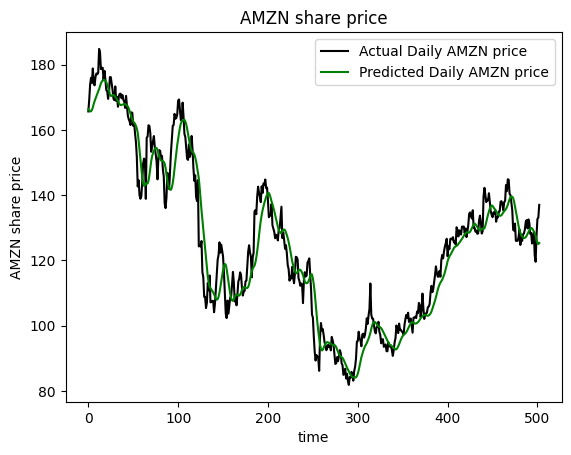

In [365]:
# Plot the actual prices using a black line
plt.plot(actual_prices, color='black', label=f"Actual Daily AMZN price")

# Plot the predicted prices using a green line
plt.plot(predicted_prices, color='green', label=f"Predicted Daily AMZN price")

# Set the title of the plot using the company name
plt.title(f"AMZN share price")

# Set the x-axis label as 'time'
plt.xlabel("time")

# Set the y-axis label using the company name
plt.ylabel(f"AMZN share price")

# Display a legend to differentiate the actual and predicted prices
plt.legend()

# Show the plot on the screen
plt.show()

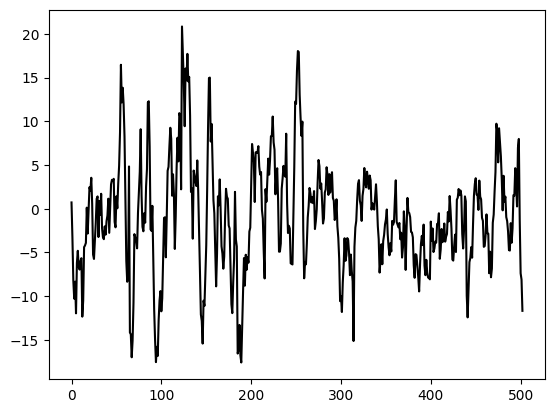

In [366]:
# plot the differences between the predicted prices and actual prices
plt.plot(predicted_prices.flatten() - actual_prices, color='black', label=f"Actual Daily AMZN price")
plt.show()

# Evaluation

In [367]:
predicted_prices1D = predicted_prices.flatten()

#using the same x_test that was input for the LSTM
#using prediction_days = 120

# Initialize an empty list to store moving averages
moving_averages = np.empty((len(predicted_prices1D), ), dtype=np.float64)

# Loop through x_test to consider
# every window of size prediction_days
for i in range(len(x_test)):

    # get the current window
    window = x_test[i].flatten()

    # Calculate the average of current window
    window_average = np.mean(window)

    # Store the average of current
    # window in moving average list
    moving_averages[i] = window_average

rolling_average = price_scaler.inverse_transform(moving_averages.reshape(-1, 1))
rolling_average = rolling_average.flatten()

In [368]:
# Average percent error

percent_error = (np.abs(actual_prices - predicted_prices1D) / actual_prices) * 100
avg_percent_error = np.sum(percent_error) / len(percent_error)
print("Avergae percent error: ", avg_percent_error)

# RMSE
# Step 1: Calculate the squared differences
squared_diff = (predicted_prices1D - actual_prices) ** 2

# Step 2: Compute the mean of squared differences
mean_squared_diff = squared_diff.mean()

# Step 3: Take the square root to get RMSE
rmse = np.sqrt(mean_squared_diff)

print("Root Mean Square Error (RMSE):", rmse)


# Out of Sample R square
# Calculate the rolling mean of the actual target values
#actual_mean = np.mean(actual_prices) # compare to rolling mean of window

# Calculate SST, SSR, and SSE
SST = np.sum((actual_prices - rolling_average) ** 2)
SSE = np.sum((actual_prices - predicted_prices1D) ** 2)

# Calculate out-of-sample R-squared
out_of_sample_r_squared = 1 - (SSE / SST)

print("Out-of-sample R-squared:", out_of_sample_r_squared)

Avergae percent error:  4.019453329510491
Root Mean Square Error (RMSE): 6.465429774703329
Out-of-sample R-squared: 0.9817188702924524


In [370]:
# 10 trials, window size = 90, units = 60

rmse = [7.744, 6.605, 6.818, 6.497, 6.499, 6.782, 7.101, 6.618, 8.345, 6.465]
oosR2 = [0.974, 0.981, 0.980, 0.982, 0.982, 0.980, 0.978, 0.981, 0.970, 0.982]
mean_rmse = sum(rmse) / len(rmse)
mean_oosR2 = sum(oosR2) / len(oosR2)

In [372]:
print(mean_rmse)
print(mean_oosR2)

6.9474
0.9789999999999999
